In [1]:
from time import time

import tensorflow as tf
import tensorflow_probability as tfp
from functools import partial

tfm = tf.math
tfl = tf.linalg
tfd = tfp.distributions
tfb = tfp.bijectors
tfl = tf.keras.layers

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('whitegrid')

from tqdm.notebook import trange

%matplotlib inline
%config InlineBackend.figure_format='retina'

KLD from q to p: 112.818 nats


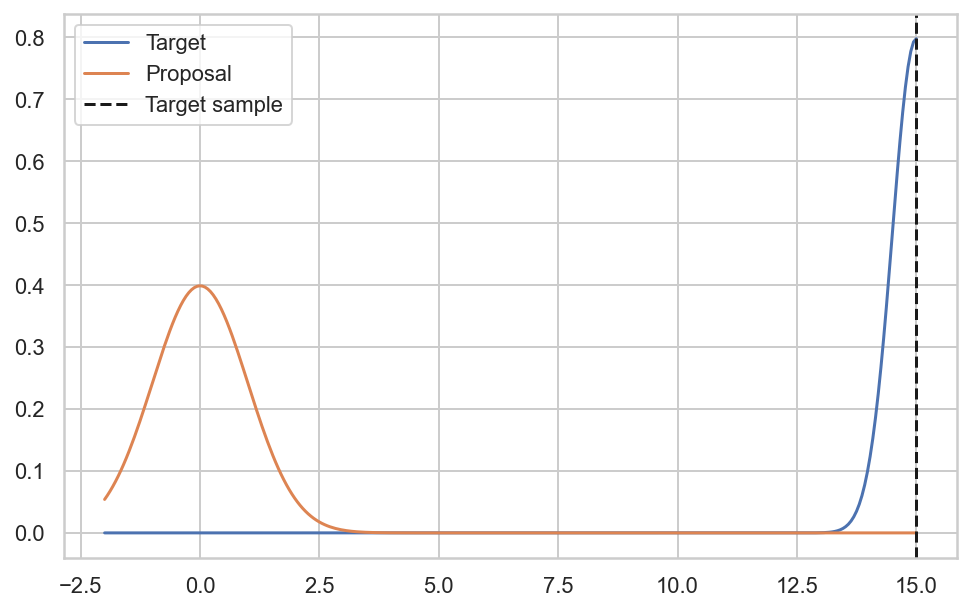

In [2]:
tf.random.set_seed(42)

q_loc = 15.
q_var = 0.25

p_loc = 0.
p_var = 1.

q = tfd.Normal(loc=q_loc, scale=tfm.sqrt(q_var))
p = tfd.Normal(loc=p_loc, scale=tfm.sqrt(p_var))

z_samp = 15.

total_kl = tfd.kl_divergence(q, p)

print(f"KLD from q to p: {total_kl:.3f} nats")

# ================================
# Plot stuff
# ================================

xs = tf.linspace(-2., 15., 300)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(xs, q.prob(xs), label="Target")
ax.plot(xs, p.prob(xs), label="Proposal")

ax.axvline(z_samp, c='k', ls='--', label="Target sample")

ax.legend()

plt.show()

# Empirical true posterior in REC

We sample $z_1, ..., z_N \sim p(z \mid \mathcal{D})$, and set $q(z) = \frac{1}{N} \sum_{n = 1}^N \delta_{z_n}(z)$.

## One sample case

If we only take a single $z_1 \sim p(z \mid \mathcal{D})$, then $q(z) = \delta_{z_1}(z)$.

In this case, we have that
$$
\begin{aligned}
    q(z \mid a_{1:k}) &= q(a_k \mid a_{1:k-1})^{-1} \delta_{z_1}(z)\prod_{i = 1}^k p(a_i \mid a_{1:i - 1}, z) \\
    &\propto \delta_{z_1}(z)\prod_{i = 1}^k p(a_i \mid a_{1:i - 1}, z)
\end{aligned}
$$
and hence, we get
$$
\begin{aligned}
    q(a_k \mid a_{1:k - 1}) &= \int p(a_k \mid a_{1:k - 1}, z) q(z \mid a_{1:k - 1}) dz \\
    &\propto \int p(a_k \mid a_{1:k - 1}, z) \delta_{z_1}(z)\prod_{i = 1}^{k - 1} p(a_i \mid a_{1:i - 1}, z) dz \\
    &= \prod_{i = 1}^k p(a_i \mid a_{1:i - 1}, z_1) \\
    &\propto p(a_k \mid a_{1:k - 1}, z_1)
\end{aligned}
$$

### Optimizing the KL
We wish to set $KL[q(a_k \mid a_{1:k - 1}) \, || \, p(a_k)]$ to $\Omega$. We note that
$$
\begin{aligned}
KL[q(a_k \mid a_{1:k - 1}) \, || \, p(a_k)] &= \mathbb{E}_{q(a_{1:k})}\left[ \log\frac{q(a_k \mid a_{1:k - 1})}{p(a_k)} \right] \\
&\approx \frac{1}{M}\sum_{m = 1}^M \mathbb{E}_{q(a_k \mid a_{1:k - 1}^{(m)})}\left[ \log\frac{q(a_k \mid a_{1:k - 1}^{(m)})}{p(a_k)} \right] \quad \text{where } a_{1:k - 1} \sim q(a_{1:k - 1})
\end{aligned}
$$

In [3]:
omega = 8.
epsilon = 0.

num_aux = int(tfm.ceil(total_kl / omega))
print(f"KL: {total_kl:.3f}, Omega: {omega}, num auxiliaries: {num_aux}")

KL: 112.818, Omega: 8.0, num auxiliaries: 15


In [4]:
def p_ak_given_traj_and_z(aux_traj, z_samp, remaining_var, aux_var_ratio):
    """
    aux_traj is a_{1:k - 1}
    remaining_var is s_{k - 1}^2
    aux_var_ratio is sigma_k^2 / s_{k - 1}^2
    """
    
    b = tf.reduce_sum(aux_traj, axis=1)
    s_k = (1. - aux_var_ratio) * remaining_var
    
    mean = (z_samp - b) * aux_var_ratio
    var = s_k * aux_var_ratio 
    
    return mean, var

In [5]:
def sample_a_traj(z_samp, aux_var_ratios, p_var, num_samples):
    
    remaining_var = p_var
    aux_traj = tf.ones([num_samples, 0])
    
    for aux_var_ratio in aux_var_ratios:
        post_aux_mean, post_aux_var = p_ak_given_traj_and_z(aux_traj, z_samp, remaining_var, aux_var_ratio)
        
        post_aux_samp = tfd.Normal(loc=post_aux_mean, scale=tfm.sqrt(post_aux_var)).sample()
        
        aux_traj = tf.concat([aux_traj, post_aux_samp[:, None]], axis=1)
        
        remaining_var = (1. - aux_var_ratio) * remaining_var
        
    return aux_traj

In [6]:
tf.random.set_seed(4)

num_mc_samples = 1000
num_opt_steps = 500
optimizer = tf.optimizers.Adam(learning_rate=3e-3)

beta = 1.

remaining_var = p_var
remaining_kl = total_kl

aux_var_ratios = tf.zeros([0])
aux_var_ratio = 1. / num_aux


aux_variances = tf.zeros([0])

for i in range(1, num_aux):
    print(f"Optimizing aux variable {i}/{num_aux - 1}!")
    print((num_aux - i - 1) * omega)
    
    aux_var_ratio = tf.Variable(aux_var_ratio)
    pbar = trange(num_opt_steps)
    for j in pbar:
        with tf.GradientTape() as tape:

            # Sample q(a_{1:k - 1})
            aux_traj = sample_a_traj(z_samp, aux_var_ratios, p_var, num_mc_samples)

            # Calculate p(a_k | a_{1:k - 1}^(m), z)
            aux_post_loc, aux_post_var = p_ak_given_traj_and_z(aux_traj, z_samp, remaining_var, aux_var_ratio)

            aux_post = tfd.Normal(loc=aux_post_loc, scale=tfm.sqrt(aux_post_var))
            aux_prior = tfd.Normal(loc=0., scale=tfm.sqrt(aux_var_ratio * remaining_var))

            aux_kl = tfd.kl_divergence(aux_post, aux_prior)

            aux_loss = (aux_kl - omega)**2
            
            remaining_kl_loss = ((remaining_kl - aux_kl) - (num_aux - i - 1) * omega)**2
            
            loss = tf.reduce_mean(remaining_kl_loss + aux_loss)

        grad = tape.gradient(loss, (aux_var_ratio,))
        optimizer.apply_gradients(zip(grad, (aux_var_ratio,)))
        
        pbar.set_description(f"Aux var ratio: {aux_var_ratio.numpy():.5f}, Loss: {loss:.5f}")
        
    aux_variance = aux_var_ratio * remaining_var
    remaining_var -= aux_variance
    remaining_kl -= tf.reduce_mean(aux_kl)
    
    aux_var_ratios = tf.concat([aux_var_ratios, aux_var_ratio[None]], axis=0)
    aux_variances = tf.concat([aux_variances, aux_variance[None]], axis=0)
    
    print(f"Final KL at iteration {i}/{num_aux - 1}: {tf.reduce_mean(aux_kl).numpy():.5f} nats.\n"
          f"Aux variance: {aux_variance.numpy():.5f}\n"
          f"Remaining KL: {remaining_kl:.5f}/{total_kl:.5f}")

Optimizing aux variable 1/14!
104.0


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

axes[0].plot(aux_variances)
axes[1].plot(aux_var_ratios)

fig.tight_layout()
plt.show()

In [9]:
p_var - tf.reduce_sum(aux_variances)

<tf.Tensor: shape=(), dtype=float32, numpy=0.024279118>

In [22]:
class BayesianNN(tf.keras.Model):
    
    def __init__(self, 
                 num_layers: int,
                 num_hidden_units: int,
                 weight_prior_var: float = 1.,
                 likelihood_var: float = 0.04):
        super().__init__()
        
        self.num_layers = num_layers
        self.num_hidden_units = num_hidden_units
        self.weight_prior_var = weight_prior_var
        self.likelihood_var = likelihood_var
        
        self.regressor = tf.keras.Sequential([tfl.Dense(units=self.num_hidden_units,
                                                        activation=tf.nn.relu)
                                              for _ in range(self.num_layers - 1)] +
                                             [tfl.Dense(units=1)])
        
        self.weight_prior = tfd.Normal(loc=0., scale=tfm.sqrt(self.weight_prior_var))
        
    def call(self, tensor):
        return self.regressor(tensor)
    
    def prior_log_prob(self, weights):
        
        prior_lp = 0.
        num_weights = 0
        
        for w in weights:
            prior_lp += tf.reduce_sum(self.weight_prior.log_prob(w))
            num_weights += tf.size(w)
            
        return prior_lp # / tf.cast(num_weights, prior_lp.dtype)
    
    def forward_pass(self, weights, xs):
        tensor = xs
        for i, layer in enumerate(self.regressor.layers):
            tensor = tf.matmul(tensor, weights[2 * i])
            tensor = tf.nn.bias_add(tensor, weights[2 * i + 1])
            tensor = layer.activation(tensor)
            
        return tensor
    
    def joint_log_prob(self, *weights, xs, ys):
        likelihood = tfd.Normal(loc=self.forward_pass(weights, xs),
                                scale=tfm.sqrt(self.likelihood_var))
        
        return tf.reduce_sum(likelihood.log_prob(ys)) + self.prior_log_prob(weights)
    
    def sample_predictive(self, xs):
        likelihood = tfd.Normal(loc=self(xs),
                                scale=tfm.sqrt(self.likelihood_var))
        
        return likelihood.sample()

In [23]:
tf.random.set_seed(42)

num_train_data = 40
num_test_points = 200
minval = -2.
maxval = 2.

test_xs = tf.random.uniform((num_test_points, 1), minval=minval - 1., maxval=maxval + 1.)
# test_xs = tf.sort(test_xs, axis=0)
# test_xs = tf.concat([test_xs, test_xs], axis=1)
# Sort along first dim
test_xs = tf.gather(test_xs, tf.argsort(test_xs[:, 0]))

train_xs = tf.random.uniform((num_train_data, 1), minval=minval, maxval=maxval)
train_xs = tf.gather_nd(train_xs,
                        tf.where(tf.logical_or(-0.5 > train_xs[:, 0], train_xs[:, 0] > 0.4)))
# Sort along first dim
train_xs = tf.gather(train_xs, tf.argsort(train_xs[:, 0]))

num_train_data = int(tf.size(train_xs))

bnn = BayesianNN(num_layers=3,
                 num_hidden_units=10)

train_ys, test_fs = bnn.sample_predictive(train_xs), bnn(test_xs)

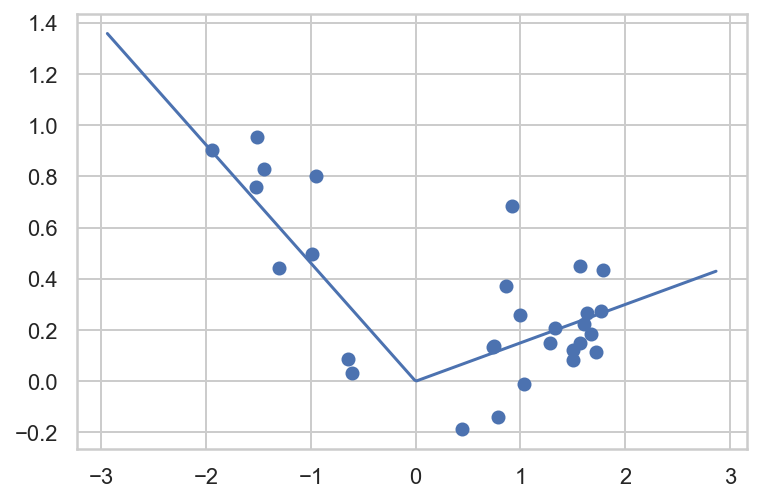

In [24]:
plt.plot(test_xs[:, 0].numpy(), test_fs[:, 0].numpy())
plt.scatter(train_xs[:, 0].numpy(), train_ys[:, 0].numpy())
plt.show()

In [29]:
# Initialize the HMC transition kernel.
num_results = int(10000)
num_burnin_steps = int(5000)

joint_log_prob = partial(bnn.joint_log_prob, xs=train_xs, ys=train_ys)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=joint_log_prob,
        num_leapfrog_steps=10,
        step_size=0.03),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=bnn.regressor.trainable_variables,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
    
    return samples, is_accepted

start_time = time()
samples, accept_rate = run_chain()
time_delta = time() - start_time

print(f"Sampling finished in {time_delta:.4f} seconds")
print(f"Acceptance: {accept_rate.numpy():.4f}")

Sampling finished in 35.6168 seconds
Acceptance: 0.4428


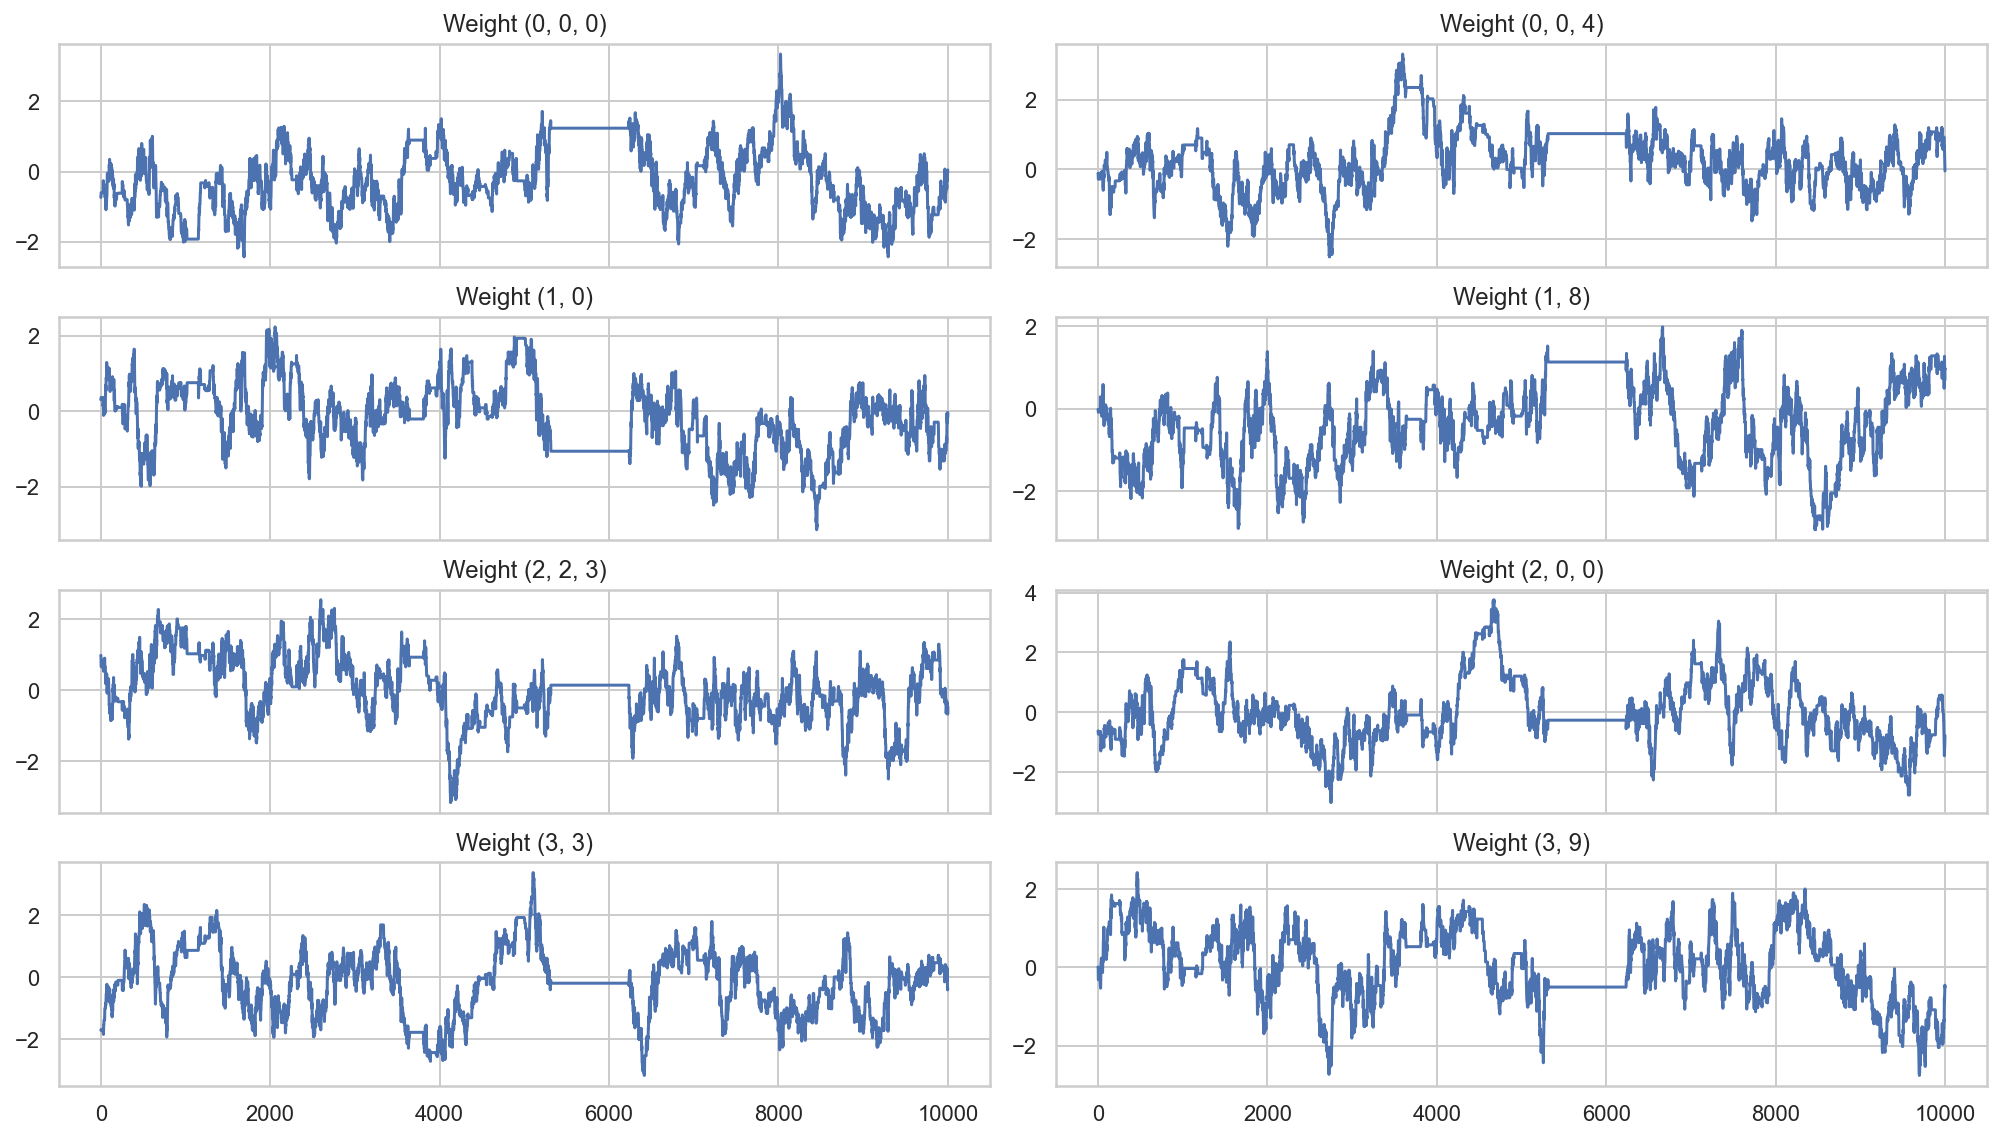

In [30]:
weight_indices_to_track = [
    (0, 0, 0),
    (0, 0, 4),
    (1, 0),
    (1, 8),
    (2, 2, 3),
    (2, 0, 0),
    (3, 3),
    (3, 9)
]

fig, axes = plt.subplots(4, 2, figsize=(14, 8), sharex=True)
axes = axes.ravel()

for ax, index in zip(axes, weight_indices_to_track):
    
    samp_path = samples[index[0]][:, index[1], index[2]] if len(index) == 3 else samples[index[0]][:, index[1]]
    
    ax.plot(samp_path)
    ax.set_title(f"Weight {index}")

fig.tight_layout()
fig.savefig('weight_traceplot.png')
plt.show()

In [31]:
preds = []

for i in range(0, num_results, 50):
    for value, v in zip(samples, bnn.regressor.trainable_variables):
        v.assign(value[i])
        
    pred = bnn(test_xs)
    preds.append(pred)
    
preds = tf.concat(preds, axis=1)
pred_mean, pred_var = tf.nn.moments(preds, axes=[1])
pred_std = tfm.sqrt(pred_var)

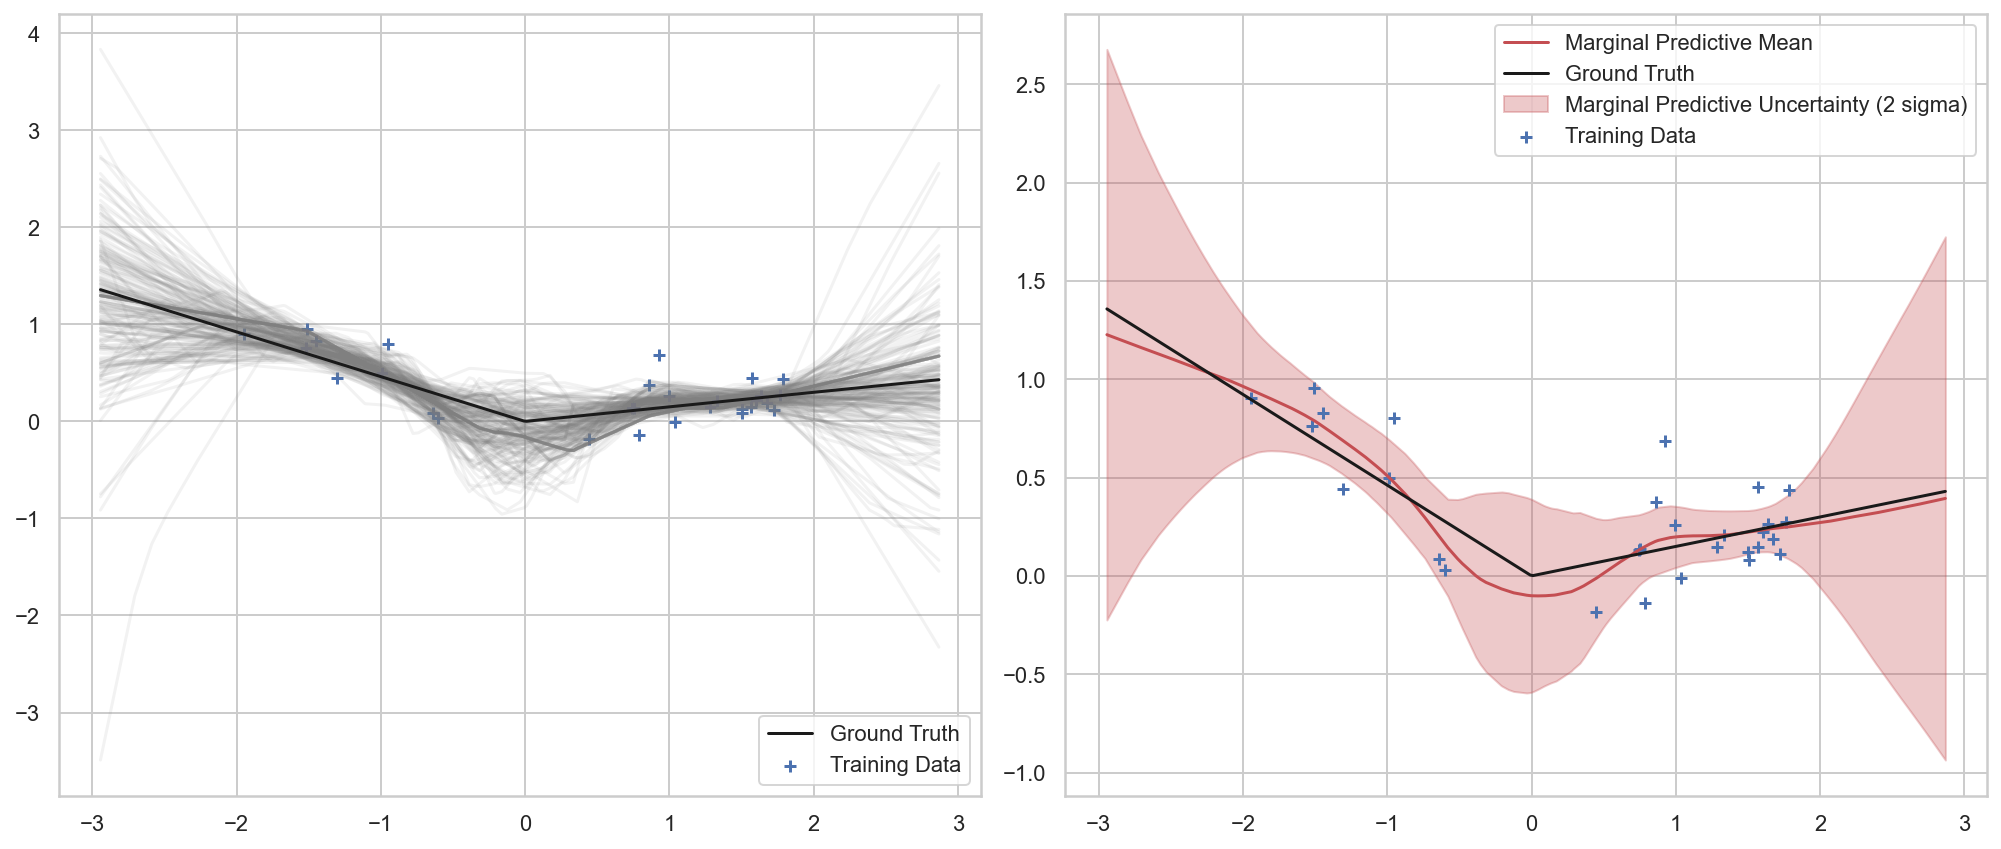

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(test_xs[:, 0].numpy(), preds.numpy(), c='gray', alpha=0.1)
axes[0].plot(test_xs[:, 0].numpy(), test_fs[:, 0].numpy(), c='k', label='Ground Truth')
axes[0].scatter(train_xs[:, 0].numpy(), train_ys[:, 0].numpy(), marker='+', c='b', label="Training Data")

axes[1].plot(test_xs[:, 0].numpy(), pred_mean.numpy(), c='r', label="Marginal Predictive Mean")
axes[1].fill_between(test_xs[:, 0].numpy(),
                    (pred_mean + 2. * pred_std).numpy(),
                    (pred_mean - 2. * pred_std).numpy(),
                    color='r', alpha=0.3, label="Marginal Predictive Uncertainty (2 sigma)")
axes[1].plot(test_xs[:, 0].numpy(), test_fs[:, 0].numpy(), c='k', label='Ground Truth')
axes[1].scatter(train_xs[:, 0].numpy(), train_ys[:, 0].numpy(), marker='+', c='b', label="Training Data")

axes[0].legend()
axes[1].legend()

fig.tight_layout()
fig.savefig('bnn_marginal_predictive.png')
plt.show()